In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# data setting


In [3]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [4]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X_train.head()

MSSubClass  LotFrontage   LotArea  Street  LotShape  LandSlope  \
0         1.8     0.454545 -0.191453     0.0       0.0        0.0   
1         0.0     0.000000 -0.289205     0.0       0.0        0.0   
2         0.0     0.136364 -0.218961     0.0       0.0        0.0   
3         0.0     0.409091  0.174260     0.0       0.0        0.0   
4         0.0     0.318182  0.105735     0.0       0.0        1.0   

   OverallQual  OverallCond  YearBuilt  YearRemodAdd  ...  SaleType_ConLw  \
0          0.0          2.0  -0.187500     -0.815789  ...             0.0   
1         -0.5          0.0   0.729167      0.342105  ...             0.0   
2          0.5          0.0   0.687500      0.289474  ...             0.0   
3         -0.5          2.0  -0.145833     -0.763158  ...             0.0   
4         -0.5          0.0   0.041667     -0.500000  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0          0.0                    1.0   
1           1.0           0.0         -1.0                    0.0   
2           0.0           0.0          0.0                    0.0   
3           0.0           0.0          0.0                    0.0   
4           0.0           0.0          0.0                    0.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                  -1.0                    0.0  
1                  -1.0                    1.0  
2                   0.0                    0.0  
3                   0.0                    0.0  
4                   0.0                    0.0  

[5 rows x 214 columns]

In [6]:
from sklearn.preprocessing import RobustScaler

# Assuming X_train, X_test, y_train, y_test are your dataframes or arrays

# 將 X_train 和 X_test 轉換為張量並移動到指定設備上
x_in = torch.tensor(X_train.values, device=device, dtype=torch.float)
x_val = torch.tensor(X_test.values, device=device, dtype=torch.float)

# 對 y_train 和 y_test 進行 RobustScaler 縮放後轉換為張量
scaler = RobustScaler()
y_in_s = torch.tensor(scaler.fit_transform(y_train.values.reshape(-1, 1)), device=device, dtype=torch.float)
y_val_s = torch.tensor(scaler.transform(y_test.values.reshape(-1, 1)), device=device, dtype=torch.float)

# 將 y_train 和 y_test 直接轉換為張量
y_in = torch.tensor(y_train.values, device=device, dtype=torch.float)
y_val = torch.tensor(y_test.values, device=device, dtype=torch.float)

In [7]:
#Xavier initialization
def init_weights(m, k=1, gain=100):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()

## Best Model: 11 hidden  with RELU act

### 1.  LG UA with l2 regulization loss + dropout

In [42]:
models_LG_UA = []
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

p = [ 0.1,0.3,0.3]

model_LG_UA = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.LeakyReLU(),
    nn.Dropout(p = 0),  # 添加 dropout
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Dropout(p = 0),  # 添加 dropout
    nn.Linear(50, H[2]),
    nn.LeakyReLU(),
    nn.Dropout(p = 0),  # 添加 dropout
    nn.Linear(H[2], D_out)
)
if torch.cuda.is_available():
    model_LG_UA.cuda()

### ---------------------RERUN---------------------------

In [43]:
#initial weight
init_weights(model_LG_UA,0.1,1)
#model_LG_UA(x_in)

In [44]:
# Assuming x_in, x_val, y_in_s, y_val_s are your tensors
initial_lr = 1e-3
stopping_lr = 5e-8
stopping_error = 0.1
optimizer = torch.optim.Adam(model_LG_UA.parameters(), lr=initial_lr)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

#use ReduceLROnPlateau as UA, lr decay
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.5, 
                                                          patience=10,
                                                          verbose=True)
epochs = 0
loss_in_list = []
loss_out_list = []

while True:
    #forward
    epochs += 1
    y_pred = model_LG_UA(x_in)
    loss_in = nn.functional.mse_loss(y_pred, y_in_s).to(device)
    y_pred_val = model_LG_UA(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val, y_val_s).to(device)
    l2 = l2_loss(model_LG_UA)
    loss_out += l2
    loss_in += l2


    #backward
    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()
    lr_scheduler.step(loss_in )

    #print out
    loss_in_list.append(loss_in.item())
    loss_out_list.append(loss_out.item())
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
    
    #check UA critiria
    if current_lr<stopping_lr:
        print('UA stop')
        break
    #check EB critiria
    if loss_in.item() < stopping_error:  # Check the item value
        print("EB stop")
        break

    


print(f'Training finished in {epochs} epochs.')

# Assuming you have moved your model to CUDA device before this loop
#models_LG_UA.append([model_LG_UA, loss_in, loss_out])


Epoch 1: Loss In 102.63130950927734, Loss Out 229.82977294921875, Learning Rate 0.001
Epoch 2: Loss In 55.259220123291016, Loss Out 114.10352325439453, Learning Rate 0.001
Epoch 3: Loss In 31.910886764526367, Loss Out 52.35950469970703, Learning Rate 0.001
Epoch 4: Loss In 17.83104133605957, Loss Out 20.412817001342773, Learning Rate 0.001
Epoch 5: Loss In 8.995723724365234, Loss Out 10.174497604370117, Learning Rate 0.001
Epoch 6: Loss In 7.090399265289307, Loss Out 17.537532806396484, Learning Rate 0.001
Epoch 7: Loss In 7.391785144805908, Loss Out 27.707361221313477, Learning Rate 0.001
Epoch 8: Loss In 7.36896276473999, Loss Out 30.565868377685547, Learning Rate 0.001
Epoch 9: Loss In 6.686853408813477, Loss Out 27.266132354736328, Learning Rate 0.001
Epoch 10: Loss In 5.29903507232666, Loss Out 20.16859245300293, Learning Rate 0.001
Epoch 11: Loss In 3.648751974105835, Loss Out 12.243829727172852, Learning Rate 0.001
Epoch 12: Loss In 2.4112789630889893, Loss Out 5.895672798156738

KeyboardInterrupt: 

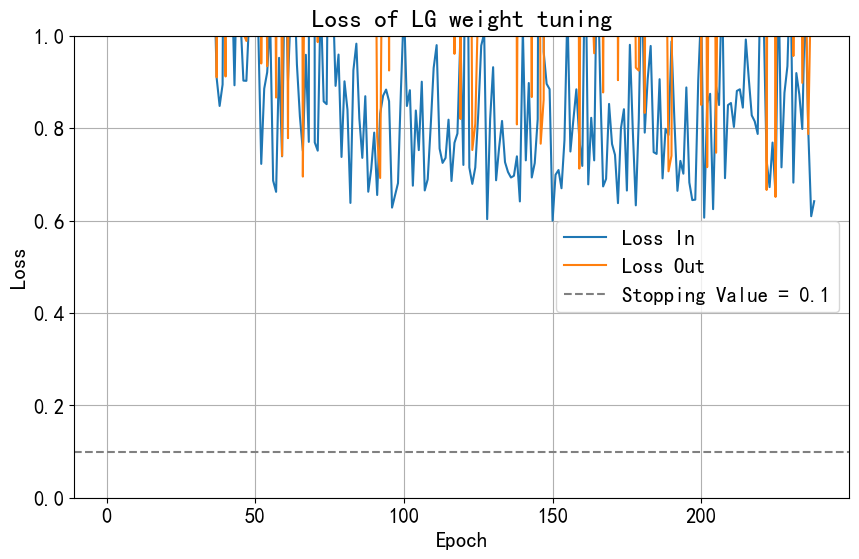

In [41]:
import matplotlib.pyplot as plt

# Assuming you have the epoch numbers as a list
epoch_list = list(range(1, epochs+1))

# Assuming you have the lists for loss_in and loss_out
loss_in_list
loss_out_list

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, loss_in_list, label='Loss In')
plt.plot(epoch_list, loss_out_list, label='Loss Out')
plt.axhline(y=stopping_error, color='gray', linestyle='--',
             linewidth=1.5, label='Stopping Value = '+str(stopping_error))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of LG weight tuning')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [16]:
y_pred_val_s = model_LG_UA(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(torch.Tensor.cpu(loss1).tolist())


y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
print(torch.Tensor.cpu(loss2).tolist())

0.266408234834671
13524982784.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_11428\4172050855.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


c:\Users\IanKu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


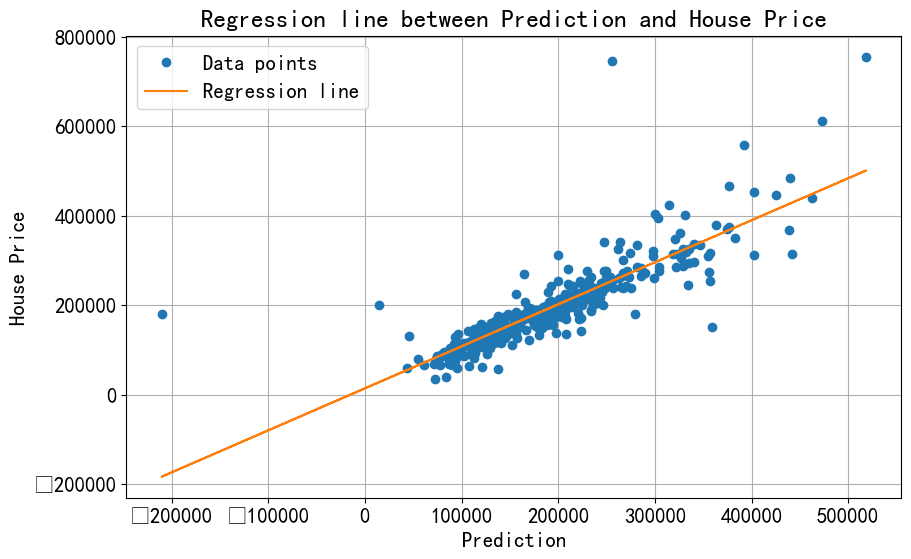

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt


#random.seed(10)
#random_draw = random.sample([i for i in range(482)], 482 // 10)
#Flatten the lists
#y_pred_val_flat = [y_pred_val_list[i] for i in random_draw]
#y_val_flat = [y_val_list[i] for i in random_draw]
#slope, intercept = np.polyfit(np.array(y_pred_val_flat).flatten(), np.array(y_val_flat).flatten(), 1)


# Convert torch tensors to lists for plotting
y_pred_val_list = y_pred_val.tolist()
y_val_list = y_val.tolist()

# Perform linear regression
slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

plt.figure(figsize=(10, 6))
plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
plt.xlabel('Prediction')
plt.ylabel('House Price')
plt.title('Regression line between Prediction and House Price')
plt.legend()
plt.grid(True)
plt.show()



### 1.5 Drop out regulization

#### set p value of dropout to be 0.5

In [18]:
dropout_probs = [ 0.5,0.4,0.3,0.3,0.2]

for name, module in model_LG_UA.named_modules():
    if isinstance(module, nn.Dropout):
        # 將 dropout 模塊的丟棄機率設置為新的值
        module.p =  dropout_probs.pop(0)

In [19]:
# Assuming x_in, x_val, y_in_s, y_val_s are your tensors
initial_lr = 1e-3
stopping_lr = 5e-8
stopping_error = 0.06
optimizer = torch.optim.Adam(model_LG_UA.parameters(), lr=initial_lr)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

#use ReduceLROnPlateau as UA, lr decay
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.8, 
                                                          patience=10,
                                                          verbose=True)
epochs = 0
loss_in_list = []
loss_out_list = []

while True:
    #forward
    epochs += 1
    y_pred = model_LG_UA(x_in)
    loss_in = nn.functional.mse_loss(y_pred, y_in_s).to(device)
    y_pred_val = model_LG_UA(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val, y_val_s).to(device)
    l2 = l2_loss(model_LG_UA)
    loss_out += l2
    loss_in += l2


    #backward
    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()
    lr_scheduler.step(loss_in )

    #print out
    loss_in_list.append(loss_in.item())
    loss_out_list.append(loss_out.item())
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
    
    #check UA critiria
    if current_lr<stopping_lr:
        print('UA stop')
        break
    #check EB critiria
    if loss_in.item() < stopping_error:  # Check the item value
        print("EB stop")
        break

    


print(f'Training finished in {epochs} epochs.')

# Assuming you have moved your model to CUDA device before this loop
models_LG_UA.append([model_LG_UA, loss_in, loss_out])


Epoch 1: Loss In 1420.885498046875, Loss Out 342.8612060546875, Learning Rate 0.001
Epoch 2: Loss In 1316.7283935546875, Loss Out 6134.3330078125, Learning Rate 0.001
Epoch 3: Loss In 921.44140625, Loss Out 22569.619140625, Learning Rate 0.001
Epoch 4: Loss In 1628.4222412109375, Loss Out 4221.1259765625, Learning Rate 0.001
Epoch 5: Loss In 310.9122009277344, Loss Out 1805.795166015625, Learning Rate 0.001
Epoch 6: Loss In 427.6552734375, Loss Out 16708.306640625, Learning Rate 0.001
Epoch 7: Loss In 462.0982666015625, Loss Out 252.79808044433594, Learning Rate 0.001
Epoch 8: Loss In 292.3829040527344, Loss Out 387.2354431152344, Learning Rate 0.001
Epoch 9: Loss In 234.03880310058594, Loss Out 4284.884765625, Learning Rate 0.001
Epoch 10: Loss In 322.4102478027344, Loss Out 894.7920532226562, Learning Rate 0.001
Epoch 11: Loss In 176.75491333007812, Loss Out 163.57748413085938, Learning Rate 0.001
Epoch 12: Loss In 220.581298828125, Loss Out 2034.01708984375, Learning Rate 0.001
Epoc

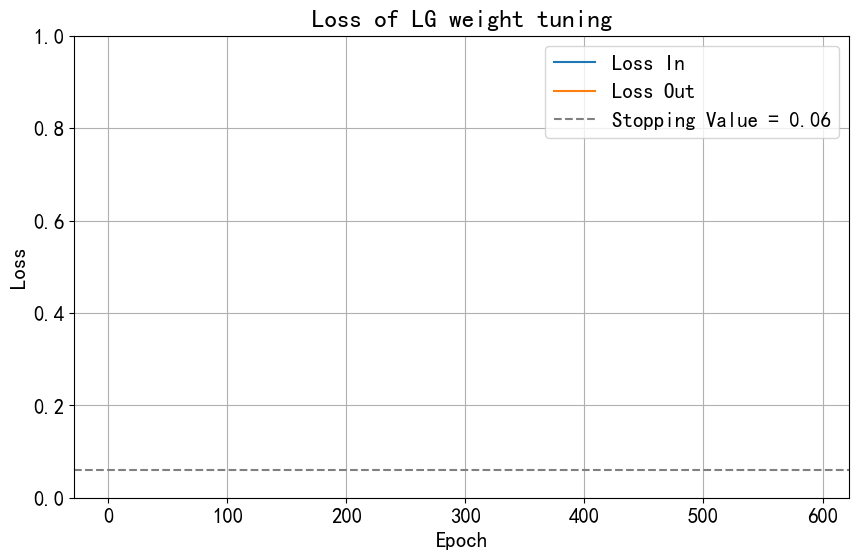

In [20]:
import matplotlib.pyplot as plt

# Assuming you have the epoch numbers as a list
epoch_list = list(range(1, epochs+1))

# Assuming you have the lists for loss_in and loss_out
loss_in_list
loss_out_list

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, loss_in_list, label='Loss In')
plt.plot(epoch_list, loss_out_list, label='Loss Out')
plt.axhline(y=stopping_error, color='gray', linestyle='--',
             linewidth=1.5, label='Stopping Value = '+str(stopping_error))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of LG weight tuning')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


### 2. Change into LG EB UA

### ---------------------RERUN---------------------------

In [61]:
models_LG_EB_UA = []
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_LG_EB_UA = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)
if torch.cuda.is_available():
    model_LG_EB_UA.cuda()

### ---------------------RERUN---------------------------

In [81]:
#initial weight
init_weights(model_LG_EB_UA,0.1,1)
#model_LG_EB_UA(x_in)

In [82]:
# Assuming x_in, x_val, y_in_s, y_val_s are your tensors
initial_lr = 1e-3
stopping_lr = 5e-8
stopping_error = 0.06
optimizer = torch.optim.Adam(model_LG_EB_UA.parameters(), lr=initial_lr)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

#use ReduceLROnPlateau as UA, lr decay
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.9, 
                                                          patience=10,
                                                          verbose=True)
epochs_limits = 50000
loss_in_list = []
loss_out_list = []

for epochs in range(50000):
    #forward
    y_pred = model_LG_EB_UA(x_in)
    loss_in = nn.functional.mse_loss(y_pred, y_in_s).to(device)
    y_pred_val = model_LG_EB_UA(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val, y_val_s).to(device)
    l2 = l2_loss(model_LG_EB_UA)
    loss_out += l2
    loss_in += l2


    #backward
    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()
    lr_scheduler.step(loss_in )

    #print out
    loss_in_list.append(loss_in.item())
    loss_out_list.append(loss_out.item())
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epochs+1}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
    
    #check UA critiria
    if current_lr<stopping_lr:
        print('UA stop')
        break
    #check EB critiria
    if loss_in.item() < stopping_error:  # Check the item value
        print("EB stop")
        break
    else:
        print("LG stop")

    


print(f'Training finished in {epochs} epochs.')

# Assuming you have moved your model to CUDA device before this loop
models_LG_EB_UA.append([model_LG_EB_UA, loss_in, loss_out])


Epoch 0: Loss In 56.34110641479492, Loss Out 111.66693878173828, Learning Rate 0.001
Epoch 1: Loss In 12.374920845031738, Loss Out 16.080398559570312, Learning Rate 0.001
Epoch 2: Loss In 4.439410209655762, Loss Out 5.142276287078857, Learning Rate 0.001
Epoch 3: Loss In 3.289731979370117, Loss Out 4.691009998321533, Learning Rate 0.001
Epoch 4: Loss In 3.4100494384765625, Loss Out 5.00813102722168, Learning Rate 0.001
Epoch 5: Loss In 3.4092981815338135, Loss Out 4.986029148101807, Learning Rate 0.001
Epoch 6: Loss In 3.2740564346313477, Loss Out 5.229708194732666, Learning Rate 0.001
Epoch 7: Loss In 2.7951478958129883, Loss Out 4.796999454498291, Learning Rate 0.001
Epoch 8: Loss In 2.186465263366699, Loss Out 3.6998023986816406, Learning Rate 0.001
Epoch 9: Loss In 1.7044161558151245, Loss Out 2.40846848487854, Learning Rate 0.001
Epoch 10: Loss In 1.6700042486190796, Loss Out 2.1293482780456543, Learning Rate 0.001
Epoch 11: Loss In 1.846623182296753, Loss Out 2.5340487957000732, 

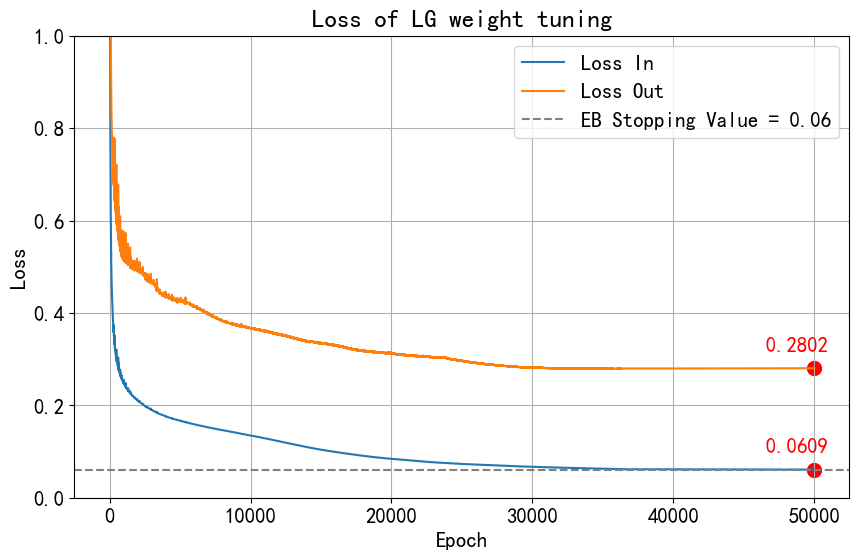

In [83]:
import matplotlib.pyplot as plt

# Assuming you have the epoch numbers as a list
epoch_list = list(range(1, epochs+2))

# Assuming you have the lists for loss_in and loss_out
loss_in_list
loss_out_list

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, loss_in_list, label='Loss In')
plt.plot(epoch_list, loss_out_list, label='Loss Out')
plt.axhline(y=stopping_error, color='gray', linestyle='--',
             linewidth=1.5, label='EB Stopping Value = '+str(stopping_error))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of LG weight tuning')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)


# Mark the last point with a big red point and write its y value
plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
plt.text(epoch_list[-1]+1000, loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
plt.text(epoch_list[-1]+1000, loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')

plt.show()


In [84]:
y_pred_val_s = model_LG_EB_UA(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(torch.Tensor.cpu(loss1).tolist())


y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
print(torch.Tensor.cpu(loss2).tolist())

0.22035165131092072
13490902016.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_17800\2545729629.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


c:\Users\IanKu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


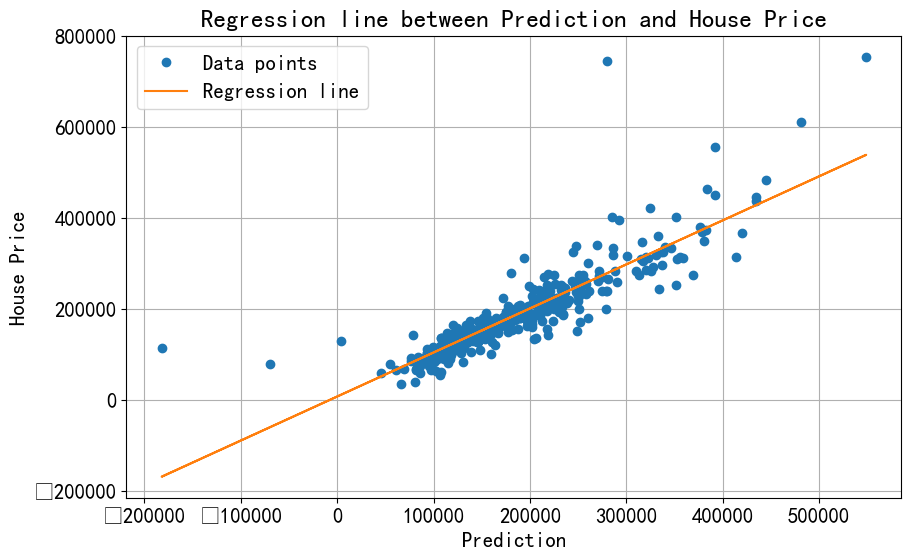

In [85]:
import random
import numpy as np
import matplotlib.pyplot as plt


#random.seed(10)
#random_draw = random.sample([i for i in range(482)], 482 // 10)
#Flatten the lists
#y_pred_val_flat = [y_pred_val_list[i] for i in random_draw]
#y_val_flat = [y_val_list[i] for i in random_draw]
#slope, intercept = np.polyfit(np.array(y_pred_val_flat).flatten(), np.array(y_val_flat).flatten(), 1)


# Convert torch tensors to lists for plotting
y_pred_val_list = y_pred_val.tolist()
y_val_list = y_val.tolist()

# Perform linear regression
slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

plt.figure(figsize=(10, 6))
plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
plt.xlabel('Prediction')
plt.ylabel('House Price')
plt.title('Regression line between Prediction and House Price')
plt.legend()
plt.grid(True)
plt.show()



## 資料來源:
[house-prices-advanced-regression-techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)
## 資料簡介:
### X 為 1460*76的房屋資料集，共有39個categorial variables，35個ordinal variables以及2個continuos variables。
##### Missing Rate
|              |total  missing | missing percentage | handling |
|--------------|---------|----------|------------|
| PoolQC       | 1453    | 99.52%   | drop       |
| MiscFeature  | 1406    | 96.30%   | drop       |
| Alley        | 1369    | 93.77%   | drop       |
| Fence        | 1179    | 80.75%   | drop       |
| FireplaceQu  | 690     | 47.26%   | Use IterativeImputer |
| LotFrontage  | 259     | 17.74%   | Use IterativeImputer |
| GarageYrBlt  | 81      | 5.55%    | Use IterativeImputer |
| GarageCond   | 81      | 5.55%    | Use IterativeImputer |
| GarageType   | 81      | 5.55%    | Use IterativeImputer | 
|             |      |  :    |  |
|             |      |  :    |  |
### y 為1460*1的房價，介於34900至755000之間，平均為180921.196，標準差為 79442.502883，稍微有點右偏，不符合常態假設。
### 因為kaggle 競賽的df_test沒有y，所以將df_train 以8:2 分成 train set和validation set。



## Conclusion
#### 這次加加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

## hidden nodes:
#### 6 layer 214*150*100*50*20*11*1 沒做drop 
## initial weight:
#### Xavier 優化了code 也丟到GPU上
## Activation:
#### 主要用RELU, Activation function 的種類影響蠻大的
## Loss:
#### MSE + l2 regulization 跑得真的比較久但是新電腦有顯卡支援
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 10^-8, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## Ensembles
#### 下次一定做
## Batch Normalization
#### 下次一定做
